# 1. Import modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.facecolor"] = "white"

# 2. Load dataset

In [2]:
# home_dir = "$HOME"
home_dir = "/gpfs/fs1/home/w/wind/batukan"
local_dir = f"{home_dir}/Documents/github/CIV1498/projects/project2"
github_dir = f"{home_dir}/Documents/github/CIV1498-Project2"

# df_LA_parcels = pd.read_csv(f"{local_dir}/Assessor_Parcels_Data_-_2006_thru_2021.csv")
# df_LA_parcels_columns = pd.Series(df_LA_parcels.columns.to_list())
# df_LA_parcels_columns.to_pickle(f"{local_dir}/df_LA_parcels_columns.pkl")

## 2.1. See available columns in the dataset

In [ ]:
df_LA_parcels_columns = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_columns.pkl")
df_LA_parcels_columns

## 2.2. Filter "Residential" parcels only

In [ ]:
df_LA_parcels_GeneralUseType = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_GeneralUseType.pkl")
Residential_index = df_LA_parcels_GeneralUseType[df_LA_parcels_GeneralUseType['GeneralUseType'] == 'Residential'].index
Residential_index.to_series().to_pickle(f"{local_dir}/index/Residential_index.pkl")

## 2.3. Filter "Single Family Residence (SFR)" parcels only

In [ ]:
# df_LA_parcels_PropertyType = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_PropertyType.pkl")
# df_LA_parcels_SpecificUseType = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_SpecificUseType.pkl").loc[Residential_index]
# Residential_SFR_index = df_LA_parcels_SpecificUseType[df_LA_parcels_SpecificUseType['SpecificUseType'] == 'Single Family Residence'].index

df_LA_parcels_PropertyType = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_PropertyType.pkl").loc[Residential_index]
Residential_SFR_index = df_LA_parcels_PropertyType[df_LA_parcels_PropertyType['PropertyType'] == 'SFR'].index
Residential_SFR_index.to_series().to_pickle(f"{local_dir}/index/Residential_SFR_index.pkl")

## 2.4. Filter "Unit == 1" parcels only

In [ ]:
df_LA_parcels_Units = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_Units.pkl").loc[Residential_SFR_index].astype(int)
Residential_SFR_Unit1_index = df_LA_parcels_Units[df_LA_parcels_Units['Units'] == 1].index
Residential_SFR_Unit1_index.to_series().to_pickle(f"{local_dir}/index/Residential_SFR_Unit1_index.pkl")

## 2.7. Get rid of parcels if "totBuildingDataLines != 1"

In [ ]:
df_LA_parcels_totBuildingDataLines = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_totBuildingDataLines.pkl").loc[Residential_SFR_Unit1_index]
Residential_SFR_Unit1_1Building_index = df_LA_parcels_totBuildingDataLines[df_LA_parcels_totBuildingDataLines['totBuildingDataLines'] == 1].index
Residential_SFR_Unit1_1Building_index.to_series().to_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_index.pkl")

## 2.8. Get rid of unusual parcels based on PropertyUseCode

In [ ]:
df_LA_parcels_PropertyUseCode = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_PropertyUseCode.pkl").loc[Residential_SFR_Unit1_1Building_index]
df_LA_parcels_PropertyUseCode_percentage = df_LA_parcels_PropertyUseCode.value_counts(normalize=True) * 100
df_LA_parcels_PropertyUseCode_percentage = df_LA_parcels_PropertyUseCode_percentage.to_frame("Percentage").reset_index()
Residential_SFR_Unit1_1Building_Regular_index = df_LA_parcels_PropertyUseCode[df_LA_parcels_PropertyUseCode['PropertyUseCode'].isin(["0100", "0101", "0103", "0104"])].index
Residential_SFR_Unit1_1Building_Regular_index.to_series().to_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_index.pkl")

plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_LA_parcels_PropertyUseCode_percentage.iloc[:5], x="PropertyUseCode", y="Percentage")
plt.title("Classification of Selected Residential Parcels in LA County by PropertyUseCode")
labels = ["No Pool", "Pool", "Planned Dev.", "Therapy Pool", "Pool and Misc."]
ax.set_xticklabels(labels);

## 2.9. Remove public parcels

In [ ]:
df_LA_parcels_SpecialParcelClassification = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_SpecialParcelClassification.pkl").loc[Residential_SFR_Unit1_1Building_Regular_index]
Residential_SFR_Unit1_1Building_Regular_Private_index = df_LA_parcels_SpecialParcelClassification[(df_LA_parcels_SpecialParcelClassification['SpecialParcelClassification'] != "Public (non-taxable government-owned)") &
(df_LA_parcels_SpecialParcelClassification['SpecialParcelClassification'] != "Public Entity (Green Code)") & 
(df_LA_parcels_SpecialParcelClassification['SpecialParcelClassification'] != "State Board of Equilization Assessed")].index

Residential_SFR_Unit1_1Building_Regular_Private_index.to_series().to_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_index.pkl")

## 2.10. Check if parcels are taxable

In [ ]:
df_LA_parcels_isTaxableParcel = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_isTaxableParcel?.pkl").loc[Residential_SFR_Unit1_1Building_Regular_Private_index]
df_LA_parcels_isTaxableParcel.value_counts(normalize=True) * 100

## 2.11. Filter parcels only in Los Angeles City (Based on ZIP code)

In [ ]:
zip_codes_los_angeles_city = pd.read_csv(f"{local_dir}/geographic/Los_Angeles_City_Zip_Codes.csv")

df_LA_parcels_ZIPcode5 = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_ZIPcode5.pkl").loc[Residential_SFR_Unit1_1Building_Regular_Private_index].dropna().astype(int)
Residential_SFR_Unit1_1Building_Regular_Private_LACity_index = df_LA_parcels_ZIPcode5[df_LA_parcels_ZIPcode5["ZIPcode5"].isin(zip_codes_los_angeles_city["ZIP"])].index
Residential_SFR_Unit1_1Building_Regular_Private_LACity_index.to_series().to_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_index.pkl")

## 2.12. Keep only RollYear 2021

In [ ]:
df_LA_parcels_LandBaseYear = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_RollYear.pkl").loc[Residential_SFR_Unit1_1Building_Regular_Private_LACity_index]

Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_index = df_LA_parcels_LandBaseYear[df_LA_parcels_LandBaseYear["RollYear"] == 2021].index
Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_index.to_series().to_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_index.pkl")

## 2.13. Calculate min distance to the bus bench or subway stop

In [ ]:
from functions import haversine
from shapely.ops import nearest_points

# Import and save shape files
gdf_LA_city_bus_benches = gpd.read_file(f"{local_dir}/geographic/Bus_Stop_Benches.shp")[["NUMBER", "geometry"]]
gdf_LA_city_bus_benches.to_pickle(f"{local_dir}/geographic/gdf_LA_city_bus_benches.pkl")
bus_points = gdf_LA_city_bus_benches.geometry.unary_union

gdf_LA_city_subway_stops = gpd.read_file(f"{local_dir}/geographic/Metro_Rail_Lines_Stops.shp")[["StopNumber", "geometry"]]
gdf_LA_city_subway_stops = gdf_LA_city_subway_stops.drop_duplicates()
gdf_LA_city_subway_stops.to_pickle(f"{local_dir}/geographic/gdf_LA_city_subway_stops.pkl")
subway_points = gdf_LA_city_subway_stops.geometry.unary_union

# Import parcel dataframes
index = Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_index

df_LA_parcels_AIN = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_AIN.pkl").loc[index]
df_LA_parcels_CENTER_LAT = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_CENTER_LAT.pkl").loc[index]
df_LA_parcels_CENTER_LON = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_CENTER_LON.pkl").loc[index]

df_LAcity_parcels = pd.concat([df_LA_parcels_AIN,
                               df_LA_parcels_CENTER_LAT,
                               df_LA_parcels_CENTER_LON], axis=1)

# Remove parcels that do not have LAT and LON coordinates
df_LAcity_parcels.dropna(inplace=True)

# Create a geodataframe with parcel coordinates
gdf_LAcity_parcels = gpd.GeoDataFrame(df_LAcity_parcels, geometry=gpd.points_from_xy(df_LAcity_parcels["CENTER_LON"], df_LAcity_parcels["CENTER_LAT"]))

df_LAcity_parcels["BusBenchClosestDist"] = [haversine(nearest_points(row[1]["geometry"], bus_points)) for row in gdf_LAcity_parcels.iterrows()]
df_LAcity_parcels["SubwayStopClosestDist"] = [haversine(nearest_points(row[1]["geometry"], subway_points)) for row in gdf_LAcity_parcels.iterrows()]

df_LAcity_parcels[["BusBenchClosestDist", "SubwayStopClosestDist"]].to_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_closest_distance_BusSubway.pkl")
Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_closest_distance_BusSubway_index = df_LAcity_parcels.index
Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_closest_distance_BusSubway_index.to_series().to_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_closest_distance_BusSubway_index.pkl")

## 2.14. Locate neighborhood of each parcel

In [ ]:
gdf_LA_city_neigborhoods = gpd.read_file(f"{local_dir}/geographic/cfbcc20d-2c5d-4c30-9dfa-627d46ec1a742020328-1-9ulknm.pzqsm.shp")

index = pd.read_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_closest_distance_BusSubway_index.pkl")

df_LA_parcels_AIN = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_AIN.pkl").loc[index]
df_LA_parcels_CENTER_LAT = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_CENTER_LAT.pkl").loc[index]
df_LA_parcels_CENTER_LON = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_CENTER_LON.pkl").loc[index]

df_LAcity_parcels = pd.concat([df_LA_parcels_AIN,
                               df_LA_parcels_CENTER_LAT,
                               df_LA_parcels_CENTER_LON], axis=1)

df_LAcity_parcels.dropna(inplace=True)
gdf_LAcity_parcels = gpd.GeoDataFrame(df_LAcity_parcels, geometry=gpd.points_from_xy(df_LAcity_parcels["CENTER_LON"], df_LAcity_parcels["CENTER_LAT"]))

gdf_LAcity_parcels["Neighborhood"] = np.nan
for row in gdf_LAcity_parcels.iterrows():
    dummy = gdf_LA_city_neigborhoods[gdf_LA_city_neigborhoods.geometry.contains(row[1]["geometry"])]["name"].to_list()
    if len(dummy) > 0:
        gdf_LAcity_parcels.loc[row[0], "Neighborhood"] = dummy

df_LAcity_parcels_neighborhood = gdf_LAcity_parcels.drop(columns=["CENTER_LAT", "CENTER_LON", "geometry", "AIN"])
df_LAcity_parcels_neighborhood.to_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_neighborhood.pkl")       

## 2.15. Cleanness of each neighborhood

In [30]:
from shapely.ops import nearest_points
# index = pd.read_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_closest_distance_BusSubway_index.pkl")
# df_LAcity_parcels_neighborhood = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_neighborhood.pkl") 
gdf_LA_city_neigborhoods = gpd.read_file(f"{local_dir}/geographic/cfbcc20d-2c5d-4c30-9dfa-627d46ec1a742020328-1-9ulknm.pzqsm.shp")
gdf_LA_city_street_cleanness = gpd.read_file(f"{local_dir}/geographic/Clean_Streets_Index_Segments_2021_B1.shp")#[['B1_2021_Sc', 'B1_2021_BI', 'B1_2021_ID', 'B1_2021_LL', 'B1_2021_Wd', "geometry"]]
gdf_LA_city_street_cleanness = gdf_LA_city_street_cleanness[['CS_RoundSc', 'BIScore', 'IDScore', 'WdsScore', 'LLScore', 'geometry']]
index = pd.read_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_closest_distance_BusSubway_index.pkl")

df_LA_parcels_AIN = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_AIN.pkl").loc[index]
df_LA_parcels_CENTER_LAT = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_CENTER_LAT.pkl").loc[index]
df_LA_parcels_CENTER_LON = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_CENTER_LON.pkl").loc[index]

df_LAcity_parcels = pd.concat([df_LA_parcels_AIN,
                               df_LA_parcels_CENTER_LAT,
                               df_LA_parcels_CENTER_LON], axis=1)

df_LAcity_parcels.dropna(inplace=True)
gdf_LAcity_parcels = gpd.GeoDataFrame(df_LAcity_parcels, geometry=gpd.points_from_xy(df_LAcity_parcels["CENTER_LON"], df_LAcity_parcels["CENTER_LAT"]))

def closest_line(lines, point):
    # get distances
    distance_list = [line.distance(point) for line in lines]
    shortest_distance = min(distance_list) # find the line closest to the point
    return(lines[distance_list.index(shortest_distance)], # return the closest line
           shortest_distance) # return the distance to that line

# df_LAcity_parcels[["C_score", "BI_score", "ID_score", "LL_score", "Wd_score"]] = np.nan   

# for row in df_LAcity_parcels.iterrows():
#     idx = closest_line(gdf_LA_city_street_cleanness.geometry.to_list(), row[1]["geometry"])[0]
#     df_LAcity_parcels[["C_score", "BI_score", "ID_score", "LL_score", "Wd_score"]].loc[row[0]] = gdf_LA_city_street_cleanness[gdf_LA_city_street_cleanness.geometry.contains(idx)][["CS_RoundSc", "BIScore", "IDScore", "WdsScore", "LLScore"]]


In [ ]:
df_LAcity_parcels[["C_score", "BI_score", "ID_score", "LL_score", "Wd_score"]] = np.nan   

for row in df_LAcity_parcels.iterrows():
    idx = closest_line(gdf_LA_city_street_cleanness.geometry.to_list(), row[1]["geometry"])[0]
    df_LAcity_parcels.loc[row[0], "C_score":"Wd_score"] = np.squeeze(gdf_LA_city_street_cleanness[gdf_LA_city_street_cleanness.geometry.contains(idx)][["CS_RoundSc", "BIScore", "IDScore", "WdsScore", "LLScore"]].values).tolist()[0]

In [56]:
df_LAcity_parcels.isnull().sum()

AIN                0
CENTER_LAT         0
CENTER_LON         0
geometry           0
C_score       628995
BI_score      628995
ID_score      628995
LL_score      628995
Wd_score      628995
dtype: int64

Text(0.5, 1.0, 'Selected Parcels in LA City')

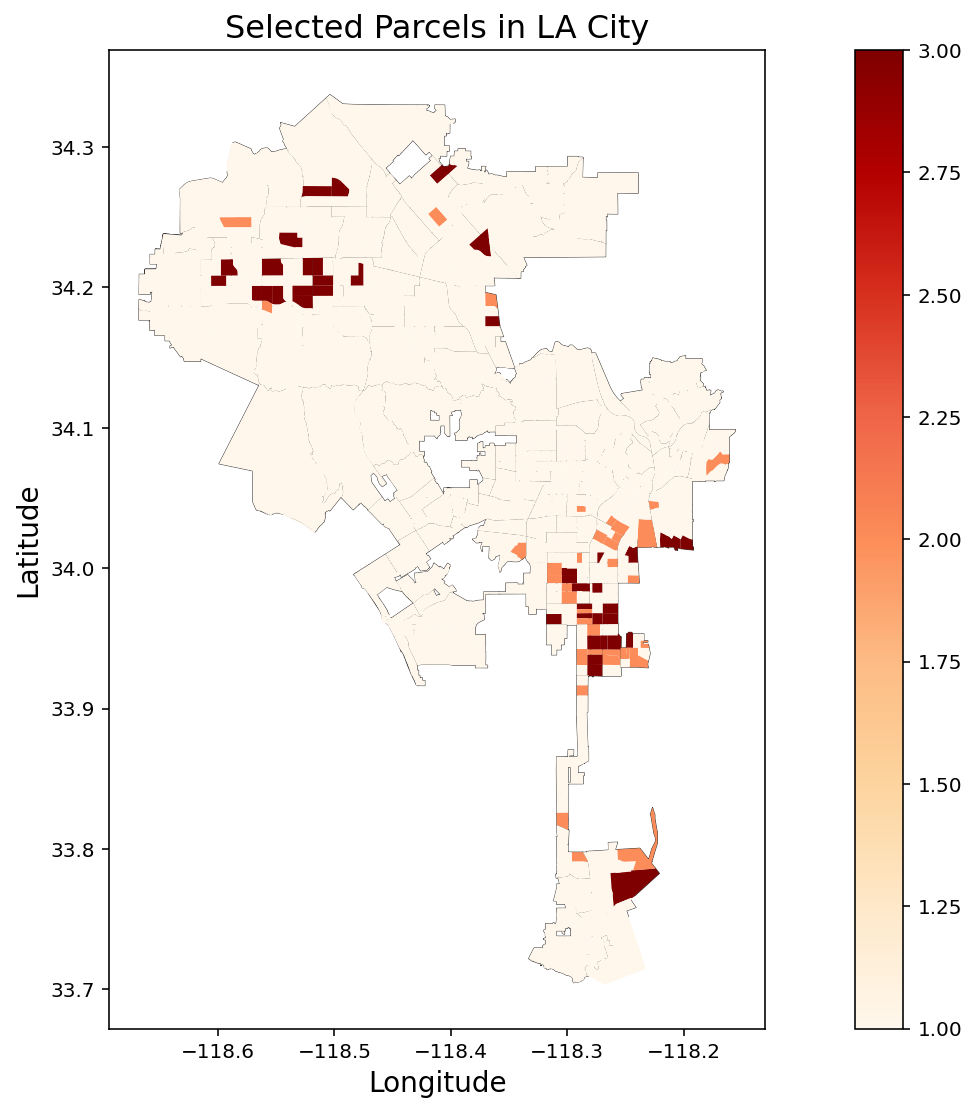

In [13]:
# Read shape file for neighborhoods in LA City
gdf_LA_city_neigborhoods = gpd.read_file(f"{local_dir}/geographic/cfbcc20d-2c5d-4c30-9dfa-627d46ec1a742020328-1-9ulknm.pzqsm.shp")

# Plot neighborhood boundaries in LA City
ax = gdf_LA_city_neigborhoods.plot(figsize=(16, 9), categorical=True, linewidth=0.5, edgecolor="0.2", alpha=1.0, color="white", legend=False)

# Add parcels to the plot above
# gpd.GeoDataFrame(df_LA_parcels_LAcity_cleaned_REV2.groupby("Neighborhood").mean(), geometry="geometry").plot(ax=ax, categorical=False, column="TotalValue", cmap="OrRd", markersize=1, legend=True, **{"linewidth":2})
df_LAcity_parcels[["C_score", "BI_score", "ID_score", "LL_score", "Wd_score", "geometry"]].plot(ax=ax, categorical=False, column="C_score", cmap="Greens", markersize=1, legend=True, **{"linewidth":2})

plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14) 
plt.title("Selected Parcels in LA City", fontsize=16)
# plt.savefig(f"{github_dir}/figures/MB/Selected_parcels_in_LAcity.png", dpi=600, bbox_inches="tight")

## 2.15. Combine and merge filtered dataframes

In [ ]:
index_final = pd.read_pickle(f"{local_dir}/index/Residential_SFR_Unit1_1Building_Regular_Private_LACity_Roll2021_closest_distance_BusSubway_index.pkl")

df_LA_parcels_AIN = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_AIN.pkl").loc[index_final]
df_LA_parcels_LandValue = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_LandValue.pkl").loc[index_final]
df_LA_parcels_LandValue["LandValue"] = df_LA_parcels_LandValue["LandValue"].str.replace(",", "").astype(float)
df_LA_parcels_LandBaseYear = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_LandBaseYear.pkl").loc[index_final]
df_LA_parcels_TotalValue = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_TotalValue.pkl").loc[index_final]
df_LA_parcels_TotalValue["TotalValue"] = df_LA_parcels_TotalValue["TotalValue"].str.replace(",", "").astype(float)
df_LA_parcels_SQFTmain = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_SQFTmain.pkl").loc[index_final]
df_LA_parcels_SQFTmain["SQFTmain"] = df_LA_parcels_SQFTmain["SQFTmain"].str.replace(",", "").astype(float)
df_LA_parcels_Bedrooms = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_Bedrooms.pkl").loc[index_final]
df_LA_parcels_Bathrooms = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_Bathrooms.pkl").loc[index_final]
df_LA_parcels_PropertyUseCode = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_PropertyUseCode.pkl").loc[index_final].astype(str)
df_LA_parcels_YearBuilt = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_YearBuilt.pkl").loc[index_final]
df_LA_parcels_EffectiveYearBuilt = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_EffectiveYearBuilt.pkl").loc[index_final]
df_LA_parcels_TaxRateArea = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_TaxRateArea.pkl").loc[index_final]
df_LA_parcels_Cluster = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_Cluster.pkl").loc[index_final]
df_LA_parcels_ZIPcode = pd.read_pickle(f"{local_dir}/dataframe/df_LA_parcels_ZIPcode.pkl").loc[index_final]
df_LA_parcels_ZIPcode[["ZIPcode5","ZIPcode4"]] = df_LA_parcels_ZIPcode["ZIPcode"].str.split('-', expand=True)
df_LA_parcels_ZIPcode = df_LA_parcels_ZIPcode.drop(columns=["ZIPcode"]).astype({"ZIPcode5": "int64"})
df_LAcity_parcels_closest_distance_BusSubway = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_closest_distance_BusSubway.pkl")
df_LAcity_parcels_neighborhood = pd.read_pickle(f"{local_dir}/dataframe/df_LAcity_parcels_neighborhood.pkl")   
parcel_boundaries_LA_cleaned = pd.read_pickle(f"{local_dir}/geographic/parcel_boundaries_LA_cleaned.pkl")

df_LA_parcels_filted = pd.concat([df_LA_parcels_AIN,
                                  df_LA_parcels_SQFTmain,
                                  df_LA_parcels_Bedrooms,
                                  df_LA_parcels_Bathrooms,
                                  df_LA_parcels_LandValue, 
                                  df_LA_parcels_LandBaseYear, 
                                  df_LA_parcels_TotalValue,
                                  df_LA_parcels_YearBuilt,
                                  df_LA_parcels_EffectiveYearBuilt,
                                  df_LA_parcels_PropertyUseCode,
                                  df_LA_parcels_TaxRateArea,
                                  df_LA_parcels_Cluster,
                                  df_LA_parcels_ZIPcode,
                                  df_LAcity_parcels_closest_distance_BusSubway,
                                  df_LAcity_parcels_neighborhood
                                  ], axis=1).merge(parcel_boundaries_LA_cleaned, how="left", on="AIN")

df_LA_parcels_LAcity_filted = df_LA_parcels_filted.dropna(subset=["Neighborhood"])
df_LA_parcels_LAcity_filted.to_pickle(f"{local_dir}/dataframe/df_LA_parcels_LAcity_filtered.pkl", compression="gzip")
df_LA_parcels_LAcity_filted.to_pickle(f"{github_dir}/dataframes/df_LA_parcels_LAcity_filtered_REV2_MB.pkl", compression="gzip")
df_LA_parcels_LAcity_filted.info()